In [1]:
# 04_clustering_evaluation_and_visualization
print("Tune K, evaluate clusters, choose final model and visualize clusters.")


Tune K, evaluate clusters, choose final model and visualize clusters.


In [1]:
# Cell 2: imports and load features + df
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib

RANDOM_STATE = 42

# load df & X_combined
df_path = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs/with_baseline_labels.csv")
X_path = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs/X_combined.npy")
assert df_path.exists() and X_path.exists(), "Run Notebook 03 to generate outputs/X_combined.npy and outputs/with_baseline_labels.csv"

df = pd.read_csv(df_path)
X = np.load(X_path)
print("Loaded X shape:", X.shape, "DF rows:", len(df))


Loaded X shape: (7787, 94) DF rows: 7787


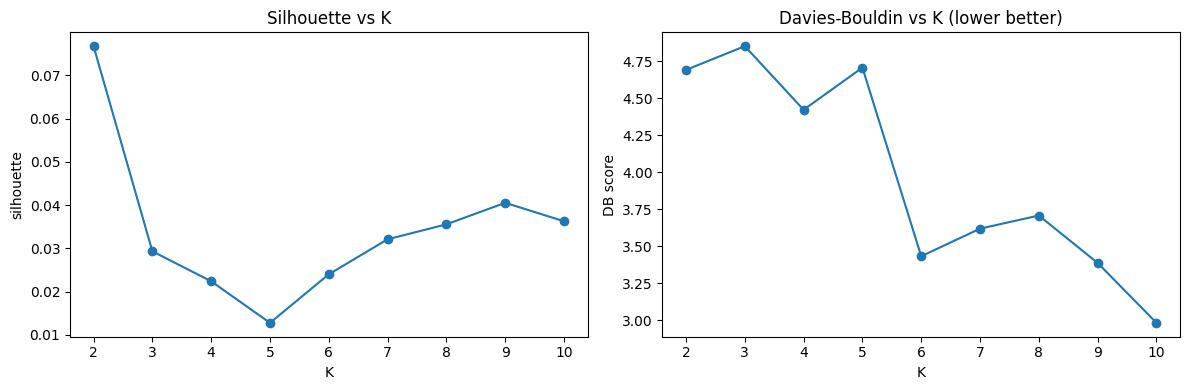

Best K by silhouette: 2 silhouette: 0.0767575770624906


In [2]:
# Cell 3: scale and sweep K (2..10)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_values = list(range(2,11))
sil_scores = []
db_scores = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_scaled)
    if len(set(labels)) > 1:
        sil = silhouette_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
    else:
        sil, db = float('nan'), float('nan')
    sil_scores.append(sil)
    db_scores.append(db)

# plot metrics
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(k_values, sil_scores, marker='o')
plt.title("Silhouette vs K")
plt.xlabel("K"); plt.ylabel("silhouette")
plt.subplot(1,2,2)
plt.plot(k_values, db_scores, marker='o')
plt.title("Davies-Bouldin vs K (lower better)")
plt.xlabel("K"); plt.ylabel("DB score")
plt.tight_layout()
plt.show()

# choose best_k by highest silhouette (break ties by lower DB)
import numpy as np
best_idx = int(np.nanargmax(np.array(sil_scores)))
best_k = k_values[best_idx]
print("Best K by silhouette:", best_k, "silhouette:", sil_scores[best_idx])


In [3]:
# Cell 4: fit final KMeans and save
final_k = int(best_k)
km_final = KMeans(n_clusters=final_k, random_state=RANDOM_STATE, n_init=10)
labels_final = km_final.fit_predict(X_scaled)
df['cluster'] = labels_final

Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs").mkdir(exist_ok=True)
df.to_csv("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs/netflix_with_clusters.csv", index=False)
joblib.dump(km_final, "C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs/kmeans_final.joblib")
joblib.dump(scaler, "C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs/scaler.joblib")
print("Saved outputs/netflix_with_clusters.csv and model artifacts")


Saved outputs/netflix_with_clusters.csv and model artifacts
